<div style="
    background-color: white;
    padding: 40px 40px;
    border-radius: 12px;
    box-shadow: 0 4px 12px rgba(255, 0, 0, 0.1);
    text-align: center;
    font-family: Arial, sans-serif;
    margin-top: 30px;
">
    <h1 style="
        color: #000000;
        font-size: 60px;
        font-weight: bold;
        margin: 0;
    ">
        Classifying News Articles
    </h1>
</div>

### IMPORT LIBRARIES

In [11]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

import warnings
warnings.filterwarnings ("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### LOADING DATA 

In [2]:
df = pd.read_csv(r"D:\Classifying _News_Articles_Project\huffpost_news_data.csv")

In [3]:
print("Columns in dataset:\n", df.columns)

Columns in dataset:
 Index(['headline', 'url', 'slug', 'short_description', 'tags', 'source',
       'source_title', 'article_section', 'author', 'primary_image',
       'language', 'description', 'raw_description', 'created_at',
       'modified_at', 'published_at', 'uniq_id', 'scraped_at'],
      dtype='object')


### SELECT TEXT + CATEGORY FIELDS

In [5]:
# finding headline-like and category columns
possible_text_cols = [c for c in df.columns if 'headline' in c.lower() or 'title' in c.lower()]
possible_cat_cols  = [c for c in df.columns if 'section' in c.lower() or 'category' in c.lower()]

print("Possible text columns:", possible_text_cols)
print("Possible category columns:", possible_cat_cols)

# If dataset has no headline column, chooseing fallback text+
if len(possible_text_cols) == 0:
    raise Exception("Can't detect any text column (headline/title). Please check your CSV.")

if len(possible_cat_cols) == 0:
    raise Exception("Can't detect category column. Please check your CSV.")

text_col = possible_text_cols[0]
cat_col  = possible_cat_cols[0]

print(f"Using text column: {text_col}")
print(f"Using category column: {cat_col}")

# Droping rows with missing text or category
df = df[[text_col, cat_col]].dropna()
df.columns = ["text", "category"]

Possible text columns: ['headline', 'source_title']
Possible category columns: ['article_section']
Using text column: headline
Using category column: article_section


### FILTER OR MAP CATEGORIES

In [8]:
# unique categories, top few (like 5–7)
top_cats = df['category'].value_counts().nlargest(7).index.tolist()
df = df[df['category'].isin(top_cats)].reset_index(drop=True)

In [9]:
print("Selected categories:\n", df['category'].value_counts())

Selected categories:
 category
Politics         1024
Entertainment     505
Wellness          366
Business          289
Parenting         214
Videos            150
Women             142
Name: count, dtype: int64


### TEXT CLEANING

In [12]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(clean_text)

### LABEL ENCODING

In [13]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['category'])
num_classes = df['label'].nunique()

### SPLIT DATA

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

### MODEL 1) TF-IDF + LOGISTIC REGRESSION

Logistic Regression Accuracy: 0.5910780669144982
               precision    recall  f1-score   support

     Business       0.68      0.22      0.34        58
Entertainment       0.67      0.51      0.58       101
    Parenting       0.81      0.51      0.63        43
     Politics       0.54      0.98      0.70       205
       Videos       0.00      0.00      0.00        30
     Wellness       0.63      0.36      0.46        73
        Women       0.83      0.18      0.29        28

     accuracy                           0.59       538
    macro avg       0.60      0.39      0.43       538
 weighted avg       0.60      0.59      0.54       538



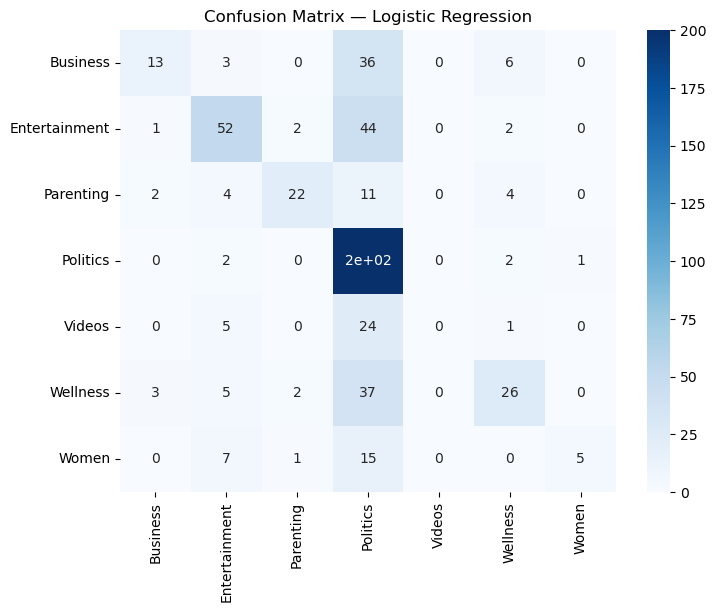

In [15]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)

y_pred_lr = log_reg.predict(X_test_tfidf)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))

cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8,6))
sns.heatmap(cm_lr, annot=True, cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix — Logistic Regression")
plt.show()

### MODEL 2) LSTM WITH EMBEDDINGS

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.3683 - loss: 1.7809 - val_accuracy: 0.4074 - val_loss: 1.6885
Epoch 2/3
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3776 - loss: 1.7404 - val_accuracy: 0.4074 - val_loss: 1.7098
Epoch 3/3
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3776 - loss: 1.7238 - val_accuracy: 0.4074 - val_loss: 1.7058
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 
LSTM Accuracy: 0.38104089219330856
               precision    recall  f1-score   support

     Business       0.00      0.00      0.00        58
Entertainment       0.00      0.00      0.00       101
    Parenting       0.00      0.00      0.00        43
     Politics       0.38      1.00      0.55       205
       Videos       0.00      0.00      0.00        30
     Wellness       0.00      0.00      0.00        73
        Women       0.00      0.00      0.00        28

     accuracy                           0.38       538
    macro avg       0.05      0.14      0.08     

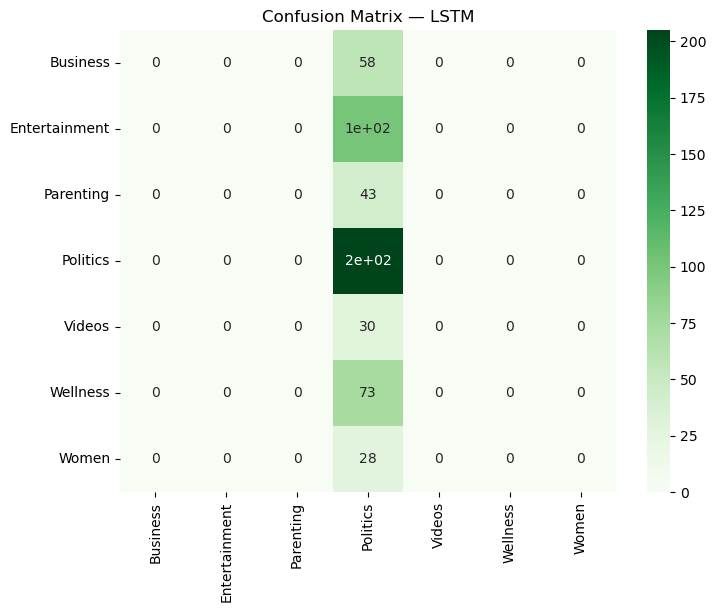

In [16]:
max_words = 20000
max_len   = 30

tk = Tokenizer(num_words=max_words, oov_token="<OOV>")
tk.fit_on_texts(X_train)

train_seq = tk.texts_to_sequences(X_train)
test_seq  = tk.texts_to_sequences(X_test)

X_train_pad = pad_sequences(train_seq, maxlen=max_len, padding='post')
X_test_pad  = pad_sequences(test_seq, maxlen=max_len, padding='post')

model = Sequential([
    Embedding(max_words, 100, input_length=max_len),
    LSTM(128),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

history = model.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=3,
    batch_size=64
)

y_pred_lstm = np.argmax(model.predict(X_test_pad), axis=1)

print("LSTM Accuracy:", accuracy_score(y_test, y_pred_lstm))
print(classification_report(y_test, y_pred_lstm, target_names=label_encoder.classes_))

cm_lstm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(8,6))
sns.heatmap(cm_lstm, annot=True, cmap="Greens",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix — LSTM")
plt.show()

### WORD CLOUDS

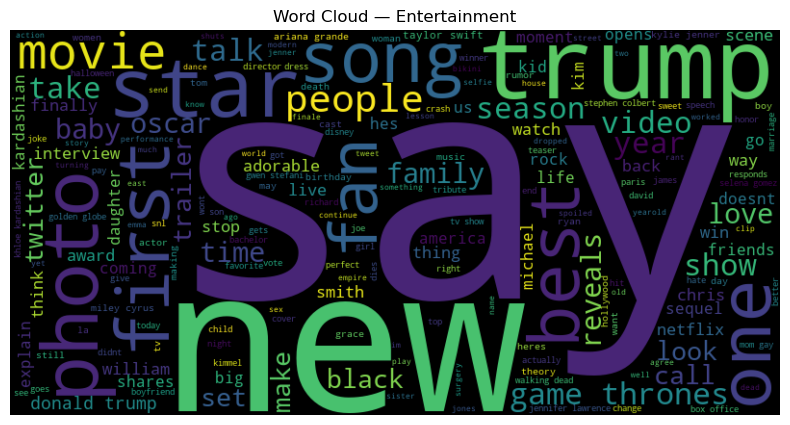

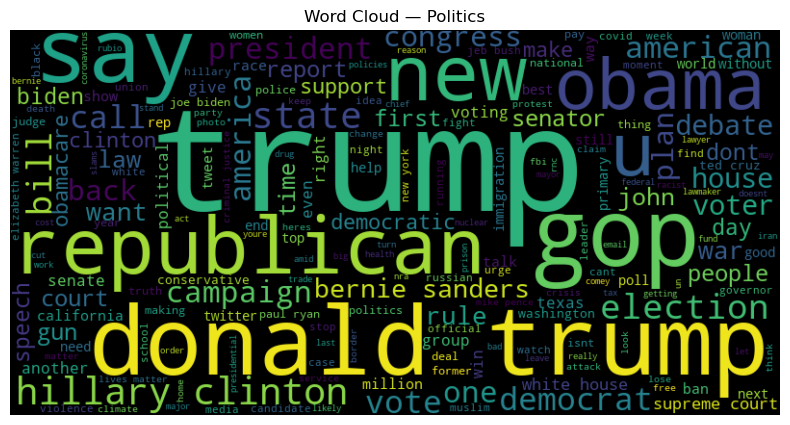

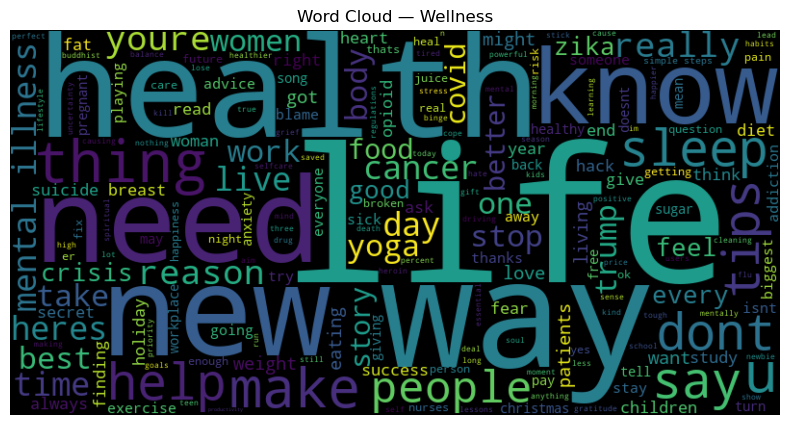

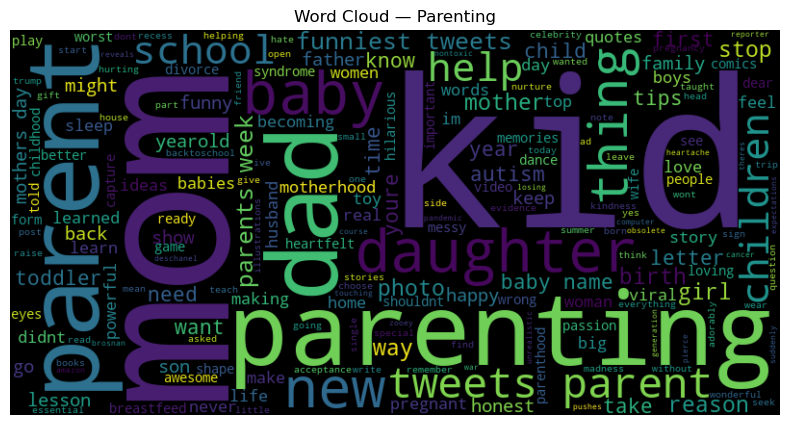

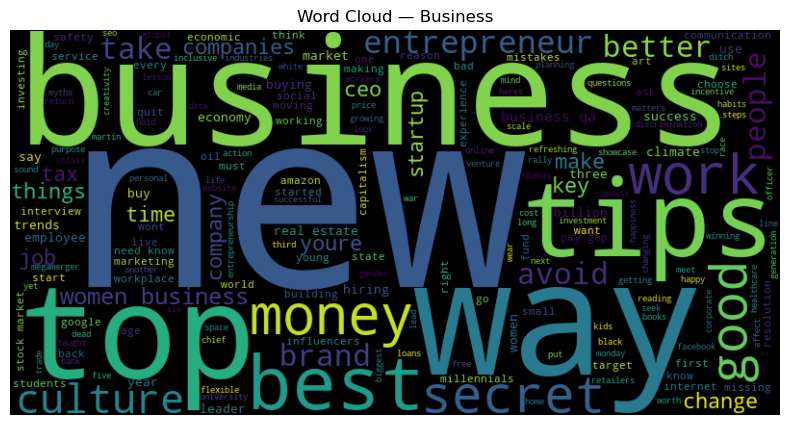

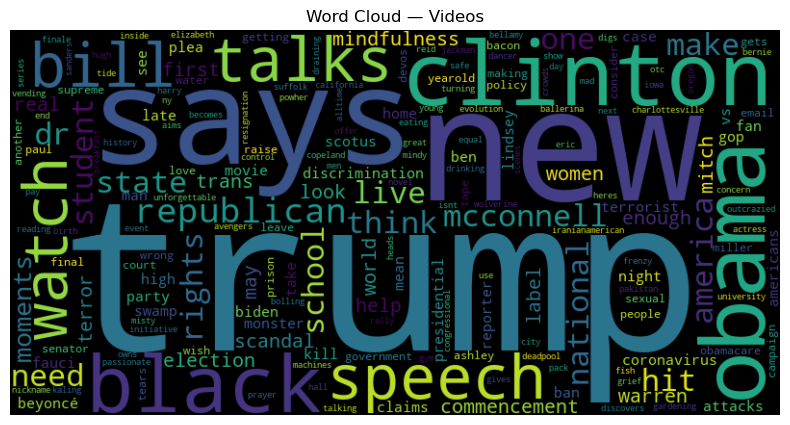

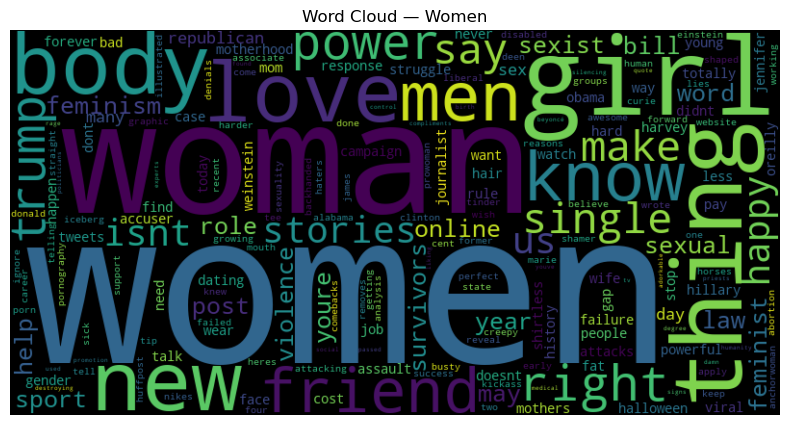

In [17]:
for cat in df['category'].unique():
    text = " ".join(df[df['category'] == cat]['clean_text'])
    wc = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud — {cat}")
    plt.show()

### MODEL ACCURACY COMPARISON

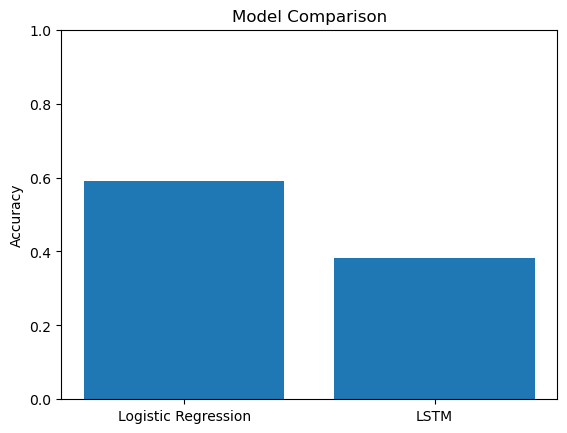

In [18]:
names = ["Logistic Regression", "LSTM"]
accs = [
    accuracy_score(y_test, y_pred_lr),
    accuracy_score(y_test, y_pred_lstm)
]

plt.bar(names, accs)
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.ylim(0,1)
plt.show()